In [1]:
##################################   Environment Setup   ########################################

#Import stuff
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Get the plotting functions
import sys
sys.path.append(r"c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions")
from Plots import plot_losses, predict_and_plot, predict_and_quiver, plot_residuals, plot_velocity_profiles, validation_by_flux

#Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
################################### Neural Network Model   #######################################
layer_size = 100
activation = nn.Tanh()  

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        #define network architecture
        self.shared = nn.Sequential(
            nn.Linear(2, layer_size),        # 2 inputs (x and y)
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            )
        # Velocity branch
        self.velocity_branch = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, 2)  # [u, v]
        )
        # Pressure branch (can be deeper/wider if you want)
        self.pressure_branch = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, layer_size),
            activation,
            nn.Linear(layer_size, 1)  # [p]
        )
        #self.apply(xavier_initialization)

    def normalize_input(self, x):
        # Assumes x is shape [N, 2] with columns [x, y]
        min_x, max_x = 0.0, 4.5      # Set to your domain bounds for x
        min_y, max_y = -0.5, 0.5     # Set to your domain bounds for y
        x_norm = 2 * (x[:, 0:1] - min_x) / (max_x - min_x) - 1
        y_norm = 2 * (x[:, 1:2] - min_y) / (max_y - min_y) - 1
        return torch.cat([x_norm, y_norm], dim=1)

    #next, define how the input flows through the network.
    def forward(self, x):
        x = self.normalize_input(x)
        features = self.shared(x)
        uv = self.velocity_branch(features)
        p = self.pressure_branch(features)
        return torch.cat([uv, p], dim=1)
    
# Xavier initialization function
# def xavier_initialization(layer):
#     if isinstance(layer, nn.Linear):
#         nn.init.xavier_normal_(layer.weight)
#         if layer.bias is not None:
#             nn.init.zeros_(layer.bias)

##**The Domain**

Next, the domain is defined.

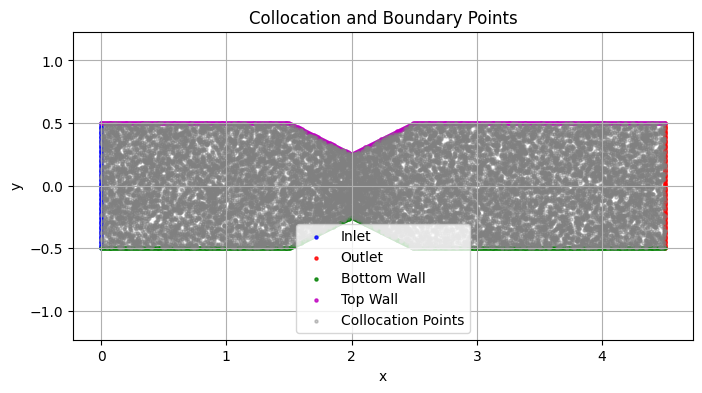

In [4]:
##############################  Boundary Points  ################################################

N_walls = 600  # numbers of points along each boundary
N_inlet = 100
N_outlet = 100

# Define the nozzle shape parameters
L_pipe_start = 1.5  # Length of the inlet straight pipe
L_pipe_end = 2.0  # Length of the outlet straight pipe
L_narrow = 0.5  # Length of the narrowing section
L_wide = 0.5 # Length of the widening section
L_total = L_pipe_start + L_narrow + L_wide + L_pipe_end  # Total domain length

x_vals_total = np.linspace(0, L_total, N_walls)  # x coordinates across the domain

h_total = np.zeros_like(x_vals_total)  # Initialize height array

# Inlet straight pipe section:
h_total[x_vals_total <= L_pipe_start] = 0.5  # Constant height

# Narrowing section:
narrow_x_start = L_pipe_start
narrow_x_end = L_pipe_start + L_narrow
mask_narrow = (x_vals_total > narrow_x_start) & (x_vals_total <= narrow_x_end)
h_total[mask_narrow] = 0.5 - 0.5 * (x_vals_total[mask_narrow] - narrow_x_start) # Linear decrease

# Widening section:
wide_x_start = narrow_x_end
wide_x_end = narrow_x_end + L_wide
mask_wide = (x_vals_total > wide_x_start) & (x_vals_total <= wide_x_end)
h_total[mask_wide] = 0.25 + 0.5 * (x_vals_total[mask_wide] - wide_x_start)  # Linear increase

# Outlet straight pipe section:
h_total[x_vals_total > wide_x_end] = 0.5  # Constant height at the end

# Top and bottom walls:
x_y_top = np.stack([x_vals_total, h_total], axis=1)
x_y_bottom = np.stack([x_vals_total, -h_total], axis=1)

# Inlet (x=0):
y_inlet = np.linspace(-h_total[0], h_total[0], N_inlet)
x_y_inlet = np.stack([np.zeros_like(y_inlet), y_inlet], axis=1)

# Outlet (x=L_total):
y_outlet = np.linspace(-h_total[-1], h_total[-1], N_outlet)
x_y_outlet = np.stack([L_total * np.ones_like(y_outlet), y_outlet], axis=1)

# Convert to torch tensors for training use
x_y_top = torch.tensor(x_y_top, dtype=torch.float32)
x_y_bottom = torch.tensor(x_y_bottom, dtype=torch.float32)
x_y_inlet = torch.tensor(x_y_inlet, dtype=torch.float32)
x_y_outlet = torch.tensor(x_y_outlet, dtype=torch.float32)


################################## Collocation points #########################################

# Generate collocation points inside the ENTIRE domain (including straight sections)
N_collocation = 20000
x_coll = np.random.uniform(0, L_total, size=(N_collocation, 1))

# Calculate height at each collocation point using the h_total function
h_x = np.interp(x_coll.flatten(), x_vals_total, h_total)  # Use interpolation

# Ensure y_coll is strictly within the domain
margin = 1e-3
y_coll = np.random.uniform(-h_x + margin, h_x - margin)
y_coll = y_coll.reshape(x_coll.shape) # Reshape to match x_coll dimensions

x_y_collocation = np.hstack([x_coll, y_coll])
x_y_collocation = torch.tensor(x_y_collocation, dtype=torch.float32, requires_grad=True)

######################## Plot collocation and boundary points   #################################
plt.figure(figsize=(8, 4))

# Plot boundary points
plt.scatter(x_y_inlet[:, 0], x_y_inlet[:, 1], s=5, c='b', label='Inlet', alpha=0.8)
plt.scatter(x_y_outlet[:, 0], x_y_outlet[:, 1], s=5, c='r', label='Outlet', alpha=0.8)
plt.scatter(x_y_bottom[:, 0], x_y_bottom[:, 1], s=5, c='g', label='Bottom Wall', alpha=0.8)
plt.scatter(x_y_top[:, 0], x_y_top[:, 1], s=5, c='m', label='Top Wall', alpha=0.8)

# Plot collocation points
x_coll_np = x_y_collocation.detach().numpy()
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], s=5, c='gray', label='Collocation Points', alpha=0.4)

plt.title("Collocation and Boundary Points")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
# plt.xlim(0, 0.5)
# plt.ylim(0, 0.6)
plt.grid(True)
plt.legend()
plt.show()

In [6]:
################ Boundary condition definition  ##############################

#Inlet - a PARABOLA
U_max = 0.002
h0 = 0.5
u_inlet = U_max * (1 - (x_y_inlet[:, 1] / h0)**2).unsqueeze(1)  # make the inlet velocity a parabola (U_max at centre and 0 at sides)
#u_inlet = torch.full_like(x_y_inlet[:, 1].unsqueeze(1), U_max)  # inlet velocity is a constant
v_inlet = torch.zeros_like(u_inlet)   # velocity in y is zero for the input
p_inlet = torch.zeros_like(u_inlet)  # optional, can be ignored or fixed to 0

target_inlet = torch.cat([u_inlet, v_inlet, p_inlet], dim=1).to(device)

# Outlet, pressure outlet
p_outlet = torch.zeros((x_y_outlet.shape[0], 1))
u_outlet = torch.zeros_like(p_outlet)
v_outlet = torch.zeros_like(p_outlet)

target_outlet = torch.cat([u_outlet, v_outlet, p_outlet], dim=1).to(device)

# Walls, all velocities zero

def compute_normals(coords):
    dx = torch.gradient(coords[:, 0])[0] # change in x
    dy = torch.gradient(coords[:, 1])[0] # change in y
    tangents = torch.stack([dx, dy], dim=1) # get tangent
    normals = torch.stack([-tangents[:, 1], tangents[:, 0]], dim=1)  # Rotate tangents 90° to get the normals
    normals = torch.nn.functional.normalize(normals, dim=1)  #normalize to unit length
    return normals



##**The loss functions**

Here the physics and the boundary loss are defined. Then, inside the train_pinn loop they are combined into the total loss.

In [7]:
#################################### Physics loss  ########################################################
def physics_loss(model, x_y, Re):
    x_y.requires_grad_(True)
    out = model(x_y)    #predict the velocities
    u = out[:, 0:1]     #get the velocity in x
    v = out[:, 1:2]     #get the velocity in y
    p = out[:, 2:3]     #get the pressure

    # Compute gradients
    grads = lambda f, wrt: torch.autograd.grad(f, wrt, grad_outputs=torch.ones_like(f), create_graph=True)[0]

    du_dx = grads(u, x_y)[:, 0:1]
    du_dy = grads(u, x_y)[:, 1:2]
    dv_dx = grads(v, x_y)[:, 0:1]
    dv_dy = grads(v, x_y)[:, 1:2]
    dp_dx = grads(p, x_y)[:, 0:1]
    dp_dy = grads(p, x_y)[:, 1:2]

    d2u_dx2 = grads(du_dx, x_y)[:, 0:1]
    d2u_dy2 = grads(du_dy, x_y)[:, 1:2]
    d2v_dx2 = grads(dv_dx, x_y)[:, 0:1]
    d2v_dy2 = grads(dv_dy, x_y)[:, 1:2]

    # Residuals of Navier-Stokes
    momentum_x = - 1 / Re * (d2u_dx2 + d2u_dy2) + u * du_dx + v * du_dy + dp_dx
    momentum_y = - 1 / Re * (d2v_dx2 + d2v_dy2) + u * dv_dx + v * dv_dy + dp_dy
    continuity = du_dx + dv_dy

    # Return the mean of the residuals
    loss_momentum_x = torch.mean(momentum_x**2)
    loss_momentum_y = torch.mean(momentum_y**2)
    loss_continuity = torch.mean(continuity**2)
    return loss_momentum_x, loss_momentum_y, loss_continuity

########################################## Boundary loss  ################################################
def boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,
                  target_inlet, target_outlet, normals_top, normals_bottom):
    # Predict
    pred_inlet = model(x_y_inlet)
    pred_outlet = model(x_y_outlet)
    pred_top = model(x_y_top)
    pred_bottom = model(x_y_bottom)

    # Inlet: match u, v (no p)
    inlet_loss = torch.mean((pred_inlet[:, 0:1] - target_inlet[:, 0:1])**2) + \
                 torch.mean((pred_inlet[:, 1:2] - target_inlet[:, 1:2])**2)

    # Outlet:
    outlet_loss = torch.mean((pred_outlet[:, 2:3] - target_outlet[:, 2:3])**2)

    # # Top and Bottom walls: no-slip
    # # --- Wall boundary: decompose into normal and tangential ---
    def decompose_wall_velocity(pred, normals):
        tangents = torch.stack([normals[:, 1], -normals[:, 0]], dim=1)  # Rotate normal -90°
        u = pred[:, 0:1]
        v = pred[:, 1:2]
        u_n = u * normals[:, 0:1] + v * normals[:, 1:2]        # normal velocity
        u_t = u * tangents[:, 0:1] + v * tangents[:, 1:2]      # tangential velocity
        return u_n, u_t

    u_n_top, u_t_top = decompose_wall_velocity(pred_top, normals_top)
    u_n_bot, u_t_bot = decompose_wall_velocity(pred_bottom, normals_bottom)

    wall_loss = torch.mean(u_n_top**2) + torch.mean(u_t_top**2) + torch.mean(u_n_bot**2) + torch.mean(u_t_bot**2)

    return inlet_loss, wall_loss, outlet_loss

##**The network training loop and a prediction**

Epoch 0 | Total Loss: 1.4719e-02 | Phys: 8.1104e-05 | BC: 1.4638e-02


c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\Plots.py:108: UserWarning: Adding colorbar to a different Figure <Figure size 500x200 with 2 Axes> than <Figure size 500x200 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


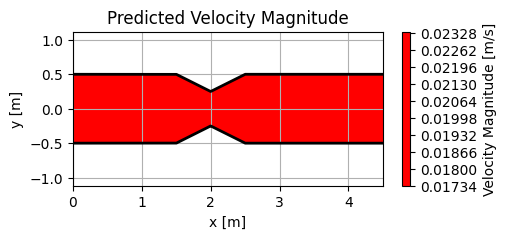

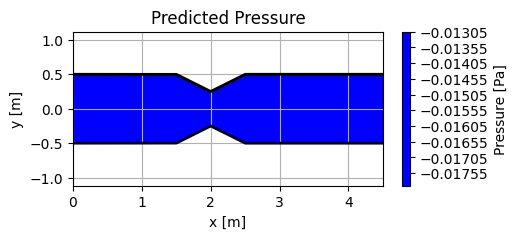

Epoch 1000 | Total Loss: 9.4546e-08 | Phys: 1.9846e-08 | BC: 7.4700e-08


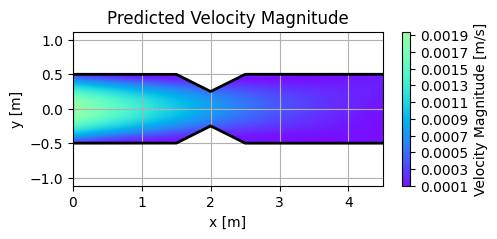

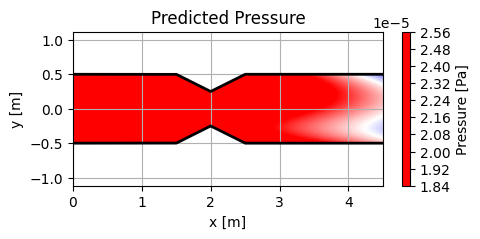

Epoch 2000 | Total Loss: 8.6954e-08 | Phys: 2.0815e-08 | BC: 6.6139e-08


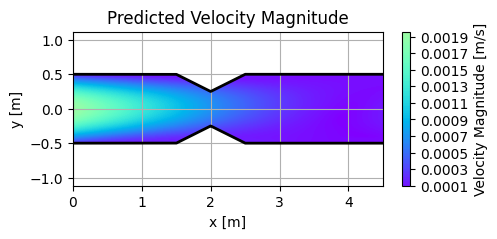

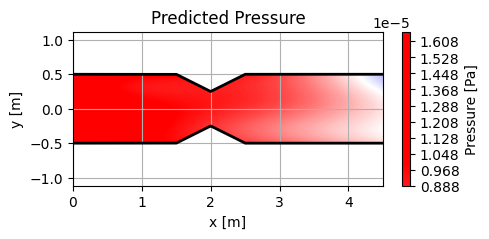

Epoch 3000 | Total Loss: 1.5453e-07 | Phys: 2.1262e-08 | BC: 1.3326e-07


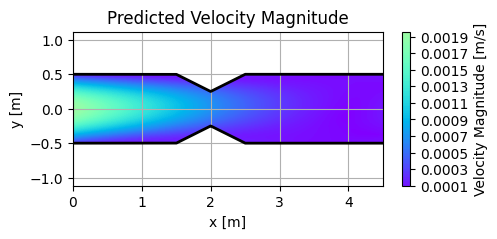

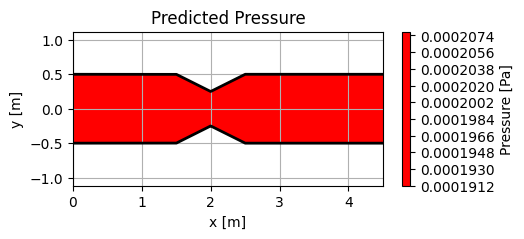

Epoch 4000 | Total Loss: 7.9121e-08 | Phys: 2.0175e-08 | BC: 5.8947e-08


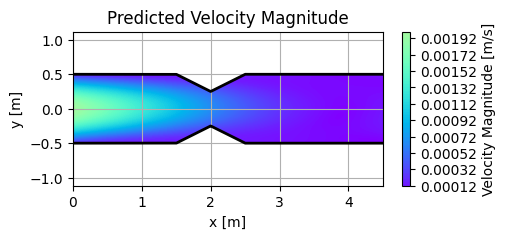

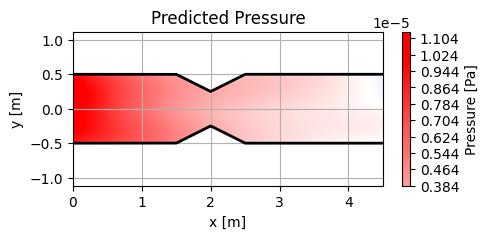

Epoch 5000 | Total Loss: 7.5666e-08 | Phys: 2.0142e-08 | BC: 5.5524e-08


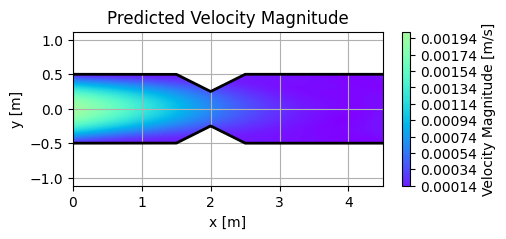

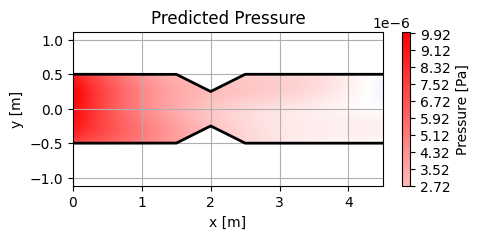

Epoch 6000 | Total Loss: 1.0187e-06 | Phys: 1.8689e-08 | BC: 1.0000e-06


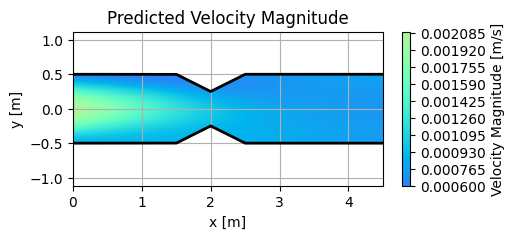

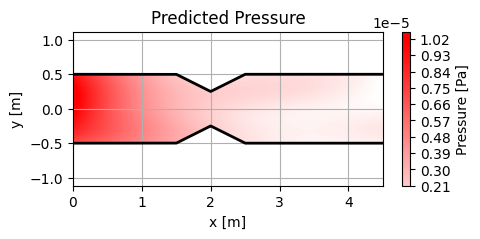

Epoch 7000 | Total Loss: 1.3011e-07 | Phys: 1.7192e-08 | BC: 1.1291e-07


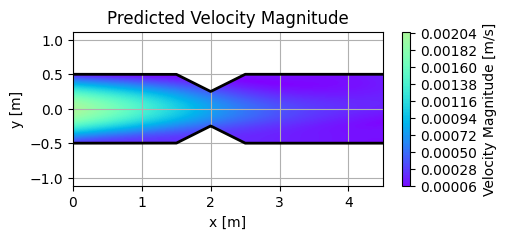

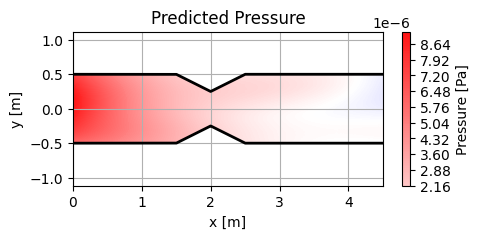

Epoch 8000 | Total Loss: 7.2105e-08 | Phys: 1.6329e-08 | BC: 5.5776e-08


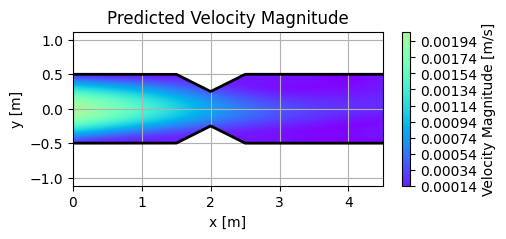

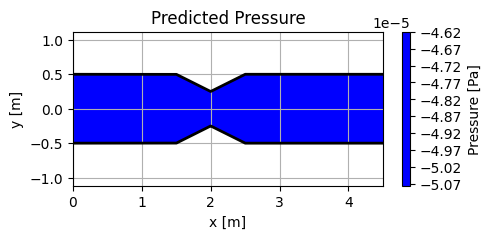

Epoch 9000 | Total Loss: 6.7522e-08 | Phys: 1.5421e-08 | BC: 5.2101e-08


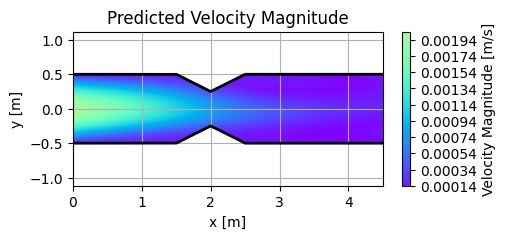

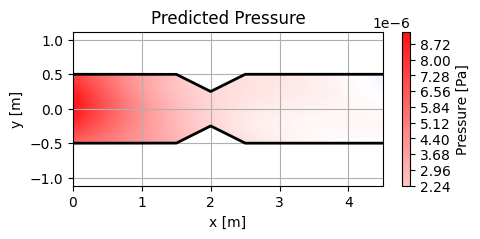

Epoch 10000 | Total Loss: 6.5159e-08 | Phys: 1.4513e-08 | BC: 5.0646e-08


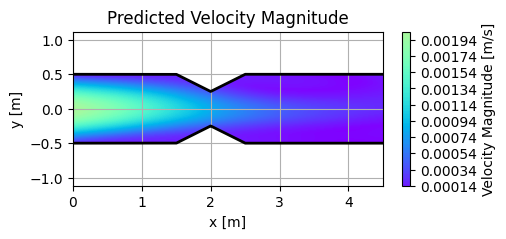

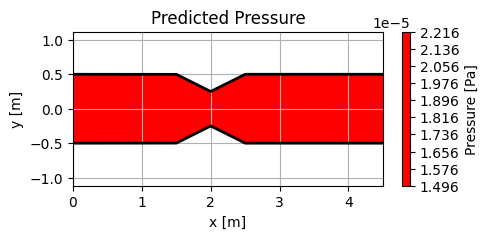

Epoch 11000 | Total Loss: 6.1451e-08 | Phys: 1.3790e-08 | BC: 4.7661e-08


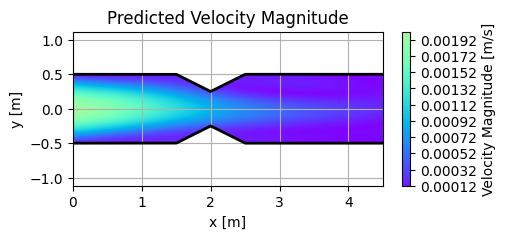

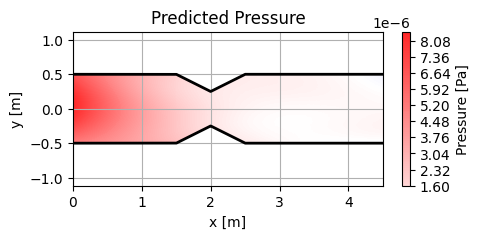

Epoch 12000 | Total Loss: 5.4910e-08 | Phys: 1.2508e-08 | BC: 4.2402e-08


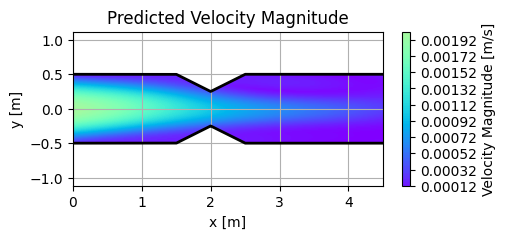

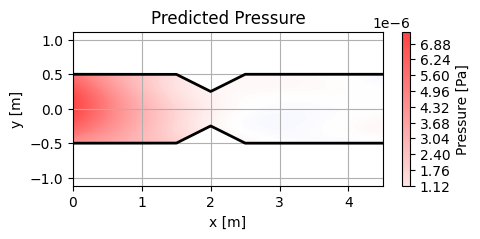

Epoch 13000 | Total Loss: 4.7506e-08 | Phys: 1.0611e-08 | BC: 3.6895e-08


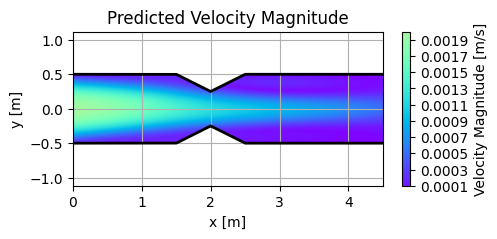

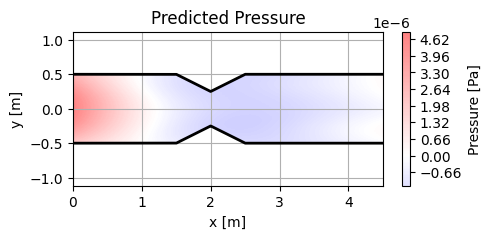

Epoch 14000 | Total Loss: 4.5924e-08 | Phys: 9.2095e-09 | BC: 3.6715e-08


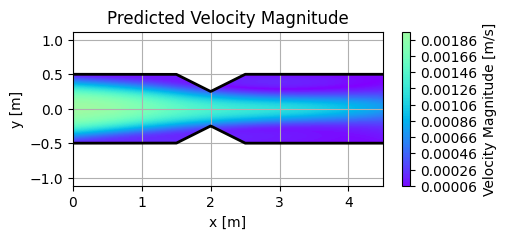

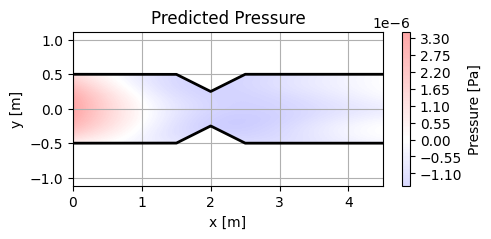

Epoch 15000 | Total Loss: 7.0604e-08 | Phys: 8.3366e-09 | BC: 6.2268e-08


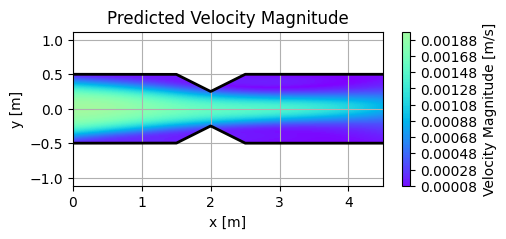

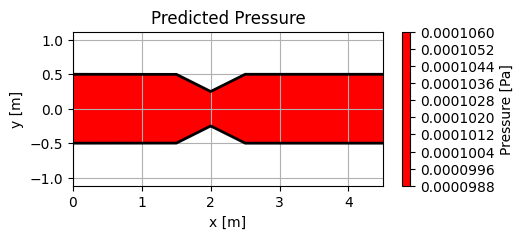

Epoch 16000 | Total Loss: 3.5690e-08 | Phys: 7.4648e-09 | BC: 2.8226e-08


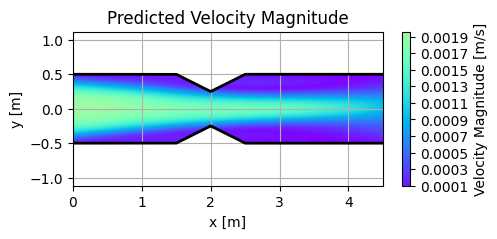

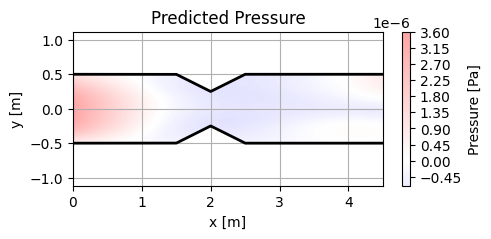

Epoch 17000 | Total Loss: 3.3120e-08 | Phys: 6.1783e-09 | BC: 2.6941e-08


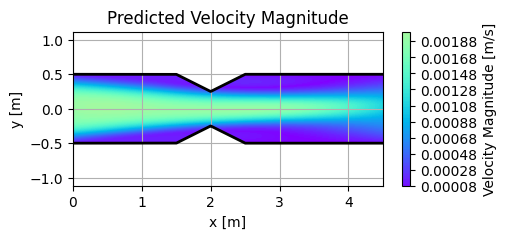

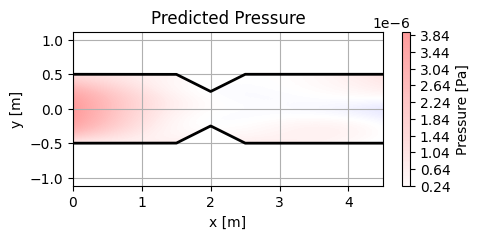

Epoch 18000 | Total Loss: 3.4399e-08 | Phys: 6.0467e-09 | BC: 2.8352e-08


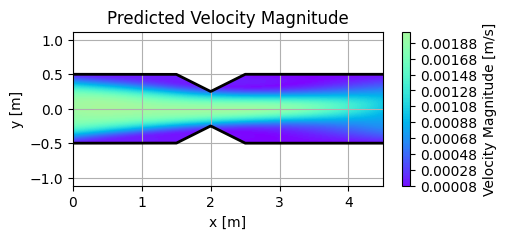

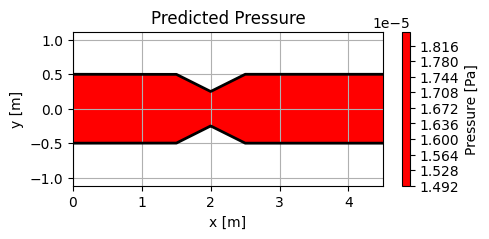

Epoch 19000 | Total Loss: 3.0520e-08 | Phys: 5.7244e-09 | BC: 2.4795e-08


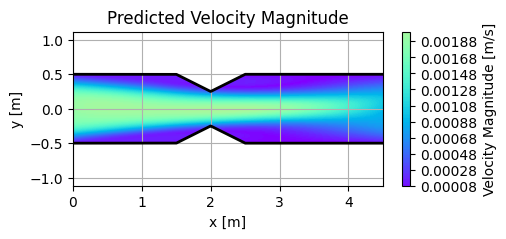

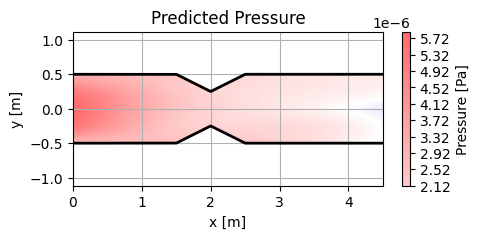

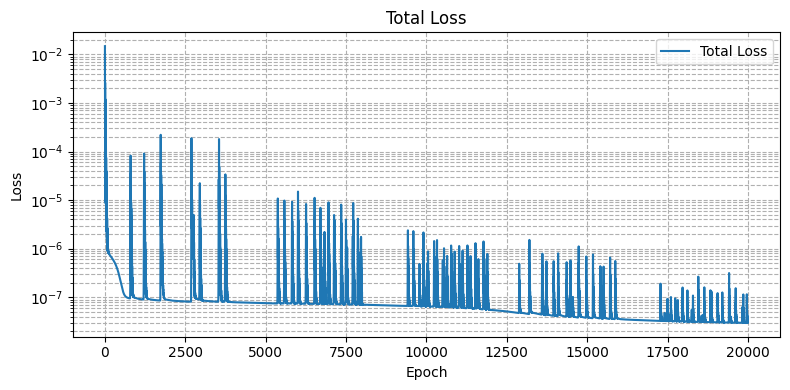

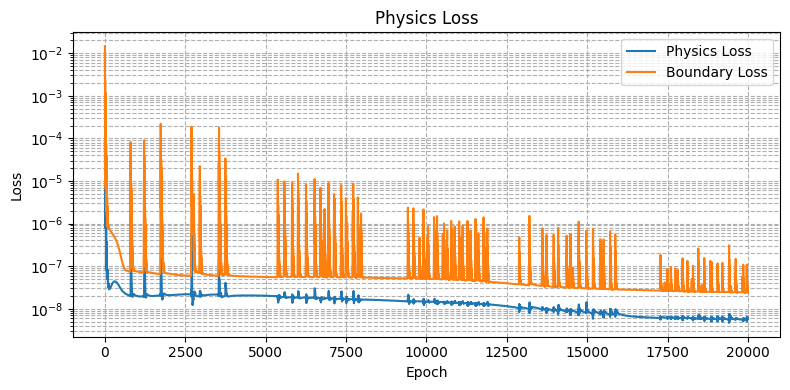

In [ ]:
#Move to GPU
x_y_collocation = x_y_collocation.to(device)
x_y_top = x_y_top.to(device)
x_y_bottom = x_y_bottom.to(device)
x_y_inlet = x_y_inlet.to(device)
x_y_outlet = x_y_outlet.to(device)

normals_top = compute_normals(x_y_top).to(device)
normals_bottom = compute_normals(x_y_bottom).to(device)

epoch_start = 0
epoch_end = 20000
lr_drop_epoch = 4000 

sections = [
        ("Inlet", 0.0, 1.5),
        ("Narrowing", 1.5, 2.0),
        ("Widening", 2.0, 2.5),
        ("Outlet", 2.5, 4.5)
    ]

#################################  Training Loop  #########################################

def train_pinn(model, x_y_collocation, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom, normals_top, normals_bottom , Re,
                      epoch_start=epoch_start, epoch_end = epoch_end, lr_drop_epoch=lr_drop_epoch):

    optimizer = optim.Adam([
        {'params': model.shared.parameters(), 'lr': 0.001},           # Shared layers
        {'params': model.velocity_branch.parameters(), 'lr': 0.001},  # Velocity branch
        {'params': model.pressure_branch.parameters(), 'lr': 0.001}  # Pressure branch 
    ])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_drop_epoch, gamma=0.5)

    x_y_collocation.requires_grad_(True)

    loss_history = []
    physics_loss_history = []
    boundary_loss_history = []
    loss_phys_x_history = []
    loss_phys_y_history = []    
    loss_continuity_history = []
    loss_bc_inlet_history = []
    loss_bc_wall_history = []
    loss_bc_outlet_history = []

    for epoch in range(epoch_start,epoch_end):

        optimizer.zero_grad()

        loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation, Re)
        loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,
                  target_inlet, target_outlet, normals_top, normals_bottom)

        loss_phys = loss_phys_x + loss_phys_y + loss_continuity
        loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
        total_loss = loss_phys + loss_bc 


        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        # Log
        loss_history.append(total_loss.item())
        physics_loss_history.append(loss_phys.item())
        boundary_loss_history.append(loss_bc.item())
        loss_phys_x_history.append(loss_phys_x.item())
        loss_phys_y_history.append(loss_phys_y.item())
        loss_continuity_history.append(loss_continuity.item())
        loss_bc_inlet_history.append(loss_bc_inlet.item())
        loss_bc_wall_history.append(loss_bc_wall.item())
        loss_bc_outlet_history.append(loss_bc_outlet.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch} | Total Loss: {total_loss.item():.4e} | Phys: {loss_phys.item():.4e} | BC: {loss_bc.item():.4e}")

        if epoch % 1000 == 0:
            fig1 = predict_and_plot(model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=0.0035, min_pres=-0.00001, max_pres=0.00001)
            torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': total_loss
}, 'trained_pinn_nozzle.pth')   # save the model for later re-loading
            
        if epoch == epoch_end - 1:
    
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': total_loss
        }, 'trained_pinn_nozzle.pth')   # save the model for later re-loading
            
    

    return model, loss_history, physics_loss_history, boundary_loss_history, optimizer, \
                    loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history

#########################   Run the training and plot the plots  ##########################

##### Values for non-dimensionalization #####
L_ref = 3.0 # Reference length for non-dimensionalization
D_ref = 1.0  # Reference diameter for non-dimensionalization
U_ref = 0.002  # Reference velocity for non-dimensionalization
U_mean = (2/3) * U_ref  # Mean velocity for the pipe flow, assuming parabolic profile
rho = 1000.0  # Density of water for non-dimensionalization
mu = 0.001   # Dynamic viscosity of water for non-dimensionalization
nu = mu / rho  # Kinematic viscosity
A = np.pi * (D_ref / 2)**2  # Cross-sectional area of the pipe
Re_inlet =  U_mean *  D_ref / nu  # Reynolds number at the inlet
Q = U_mean * A  # Volumetric flow rate
Re_nozzle = rho * Q * D_ref / (mu * A)  # Reynolds number for the nozzle part


model = PINN().to(device)
trained_model, loss_history, physics_loss_history, boundary_loss_history,  optimizer, \
    loss_phys_x_history, loss_phys_y_history, loss_continuity_history, loss_bc_inlet_history, loss_bc_wall_history, loss_bc_outlet_history = train_pinn(
    model,
    x_y_collocation,
    x_y_inlet,
    x_y_outlet,
    x_y_top,
    x_y_bottom,
    normals_top,
    normals_bottom,
    Re=Re_inlet,
    epoch_start=epoch_start,
    epoch_end=epoch_end,
    lr_drop_epoch=lr_drop_epoch)

plot_losses("Total Loss",
                    **{
                        "Total Loss": loss_history
                    })

plot_losses("Physics Loss",
                    **{ 
                        "Physics Loss": physics_loss_history,
                        "Boundary Loss": boundary_loss_history,
                    })

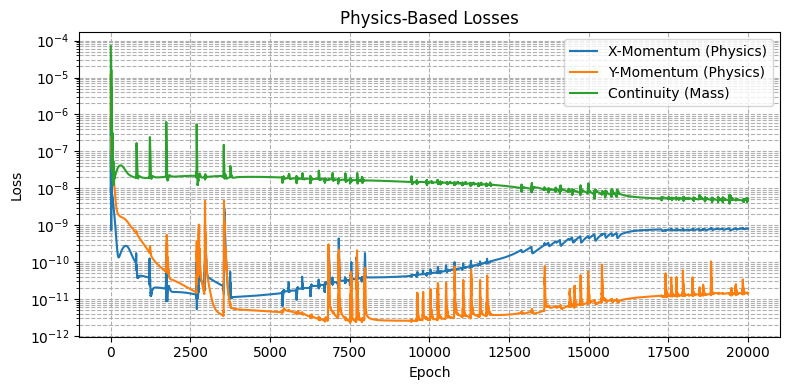

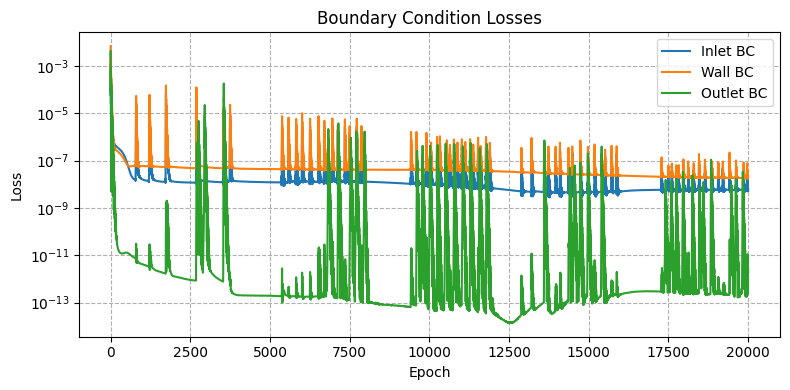

In [9]:
# First plot: Physics-related losses
plot_losses(
    "Physics-Based Losses",
    **{
        "X-Momentum (Physics)": loss_phys_x_history,
        "Y-Momentum (Physics)": loss_phys_y_history,
        "Continuity (Mass)": loss_continuity_history
    }
)

# Second plot: Boundary condition losses
plot_losses(
    "Boundary Condition Losses",
    **{
        "Inlet BC": loss_bc_inlet_history,
        "Wall BC": loss_bc_wall_history,
        "Outlet BC": loss_bc_outlet_history
    }
)

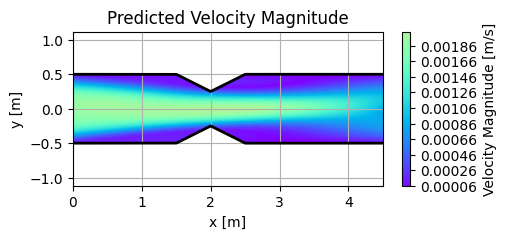

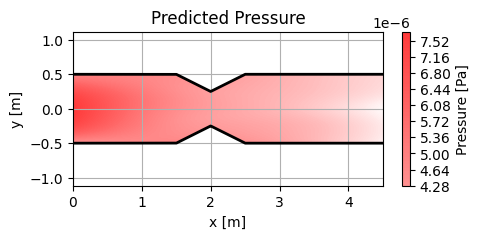

In [10]:
fig1, fig2 = predict_and_plot(trained_model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=0.0035, min_pres=-0.00001, max_pres=0.00001)

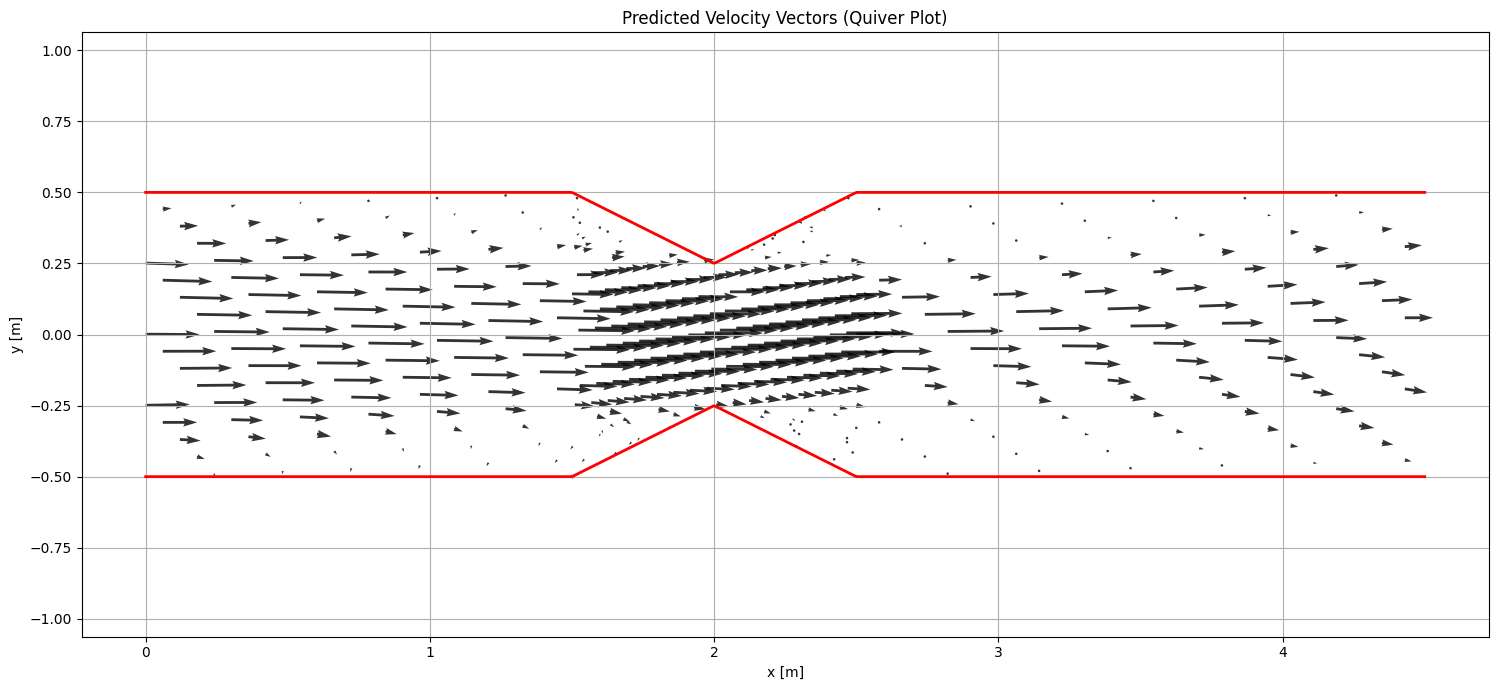

In [11]:
fig_quiver = predict_and_quiver(trained_model, device, sections, x_vals_total=x_vals_total, 
                                h_total=h_total, density=100, scale=0.01, xlim=None, ylim=None, ymin=-0.6, ymax=0.6, y_density=500)

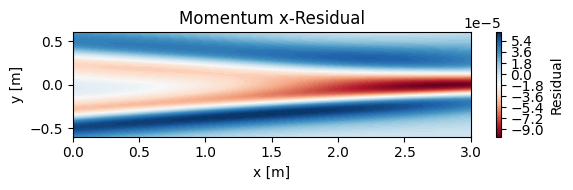

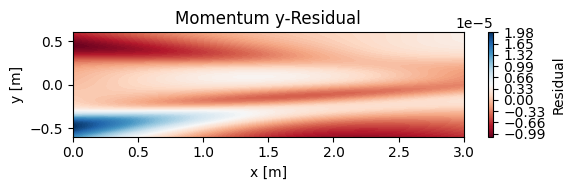

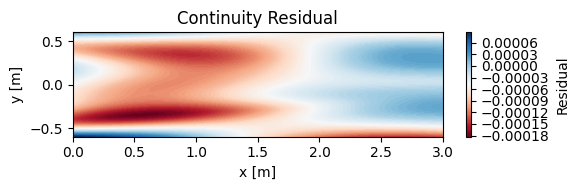

Inlet max velocity: 0.0019121128134429455
Outlet max pressure: 1.605600118637085e-06
Wall top max velocity: 0.0004194643988739699
Wall bottom max velocity: 0.0004291239893063903


In [12]:
plot_residuals(trained_model, device, x_range= (0,3), y_range = (-0.6, 0.6), x_points = 200, y_points = 100,
                   x_y_inlet=x_y_inlet, x_y_outlet=x_y_outlet, x_y_top=x_y_top, x_y_bottom=x_y_bottom)

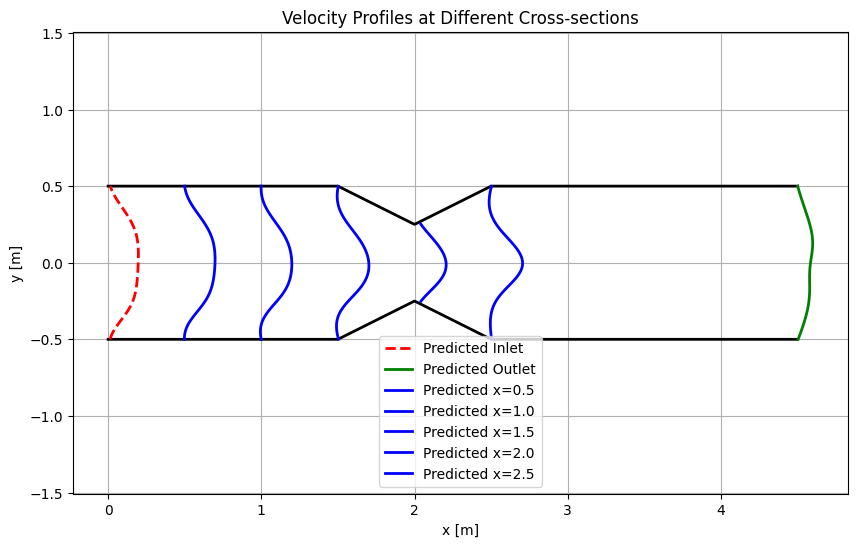

<module 'matplotlib.pyplot' from 'c:\\Users\\nv1n24\\OneDrive - University of Southampton\\PhD\\Research\\PINNs Code\\PINNsEnv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [13]:
x_locs= [0.5, 1.0, 1.5,2.0,2.5]

plot_velocity_profiles(trained_model, device, x_vals_total=x_vals_total, h_total=h_total, L_total=L_total, x_y_inlet=x_y_inlet, 
                       x_y_outlet=x_y_outlet, x_locs=x_locs, scale=100)

In [14]:
validation_by_flux(trained_model, x_vals_total, h_total, L_total)

Volumetric flow rate at inlet:  0.001293
Volumetric flow rate at outlet: 0.000642
Relative difference: 50.30%


In [15]:
crash crash crash

SyntaxError: invalid syntax (2016411700.py, line 1)

##**Continue training**

If more epochs are needed, train some more

In [19]:
########################  Train Longer!   ###################################################

#### Load the pre-trained model 
model = PINN().to(device)

checkpoint = torch.load('trained_pinn_nozzle.pth')
model.load_state_dict(checkpoint['model_state_dict'])
epoch_start = checkpoint['epoch'] + 1  # Continue from last epoch
loss = checkpoint['loss']

epoch_end = epoch_start + 10000  # Train for X more epochs

# Re-create Adam optimizer (do NOT load old optimizer state for safety)
optimizer = torch.optim.Adam([
    {'params': model.shared.parameters(), 'lr': 0.001},
    {'params': model.velocity_branch.parameters(), 'lr': 0.001},
    {'params': model.pressure_branch.parameters(), 'lr': 0.001}
])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Continue training
trained_model, new_loss_history, new_physics_loss_history, new_boundary_loss_history, optimizer, \
    new_loss_phys_x_history, new_loss_phys_y_history, new_loss_continuity_history, \
    new_loss_bc_inlet_history, new_loss_bc_wall_history, new_loss_bc_outlet_history = train_pinn(
    model,
    x_y_collocation,
    x_y_inlet,
    x_y_outlet,
    x_y_top,
    x_y_bottom,
    normals_top,
    normals_bottom,
    Re_nozzle,
    epoch_start=epoch_start,
    epoch_end=epoch_end,
    lr_drop_epoch=2000
)

# If you have previous histories, extend them. Otherwise, just use the new ones.
try:
    loss_history.extend(new_loss_history)
    physics_loss_history.extend(new_physics_loss_history)
    boundary_loss_history.extend(new_boundary_loss_history)
except NameError:
    loss_history = new_loss_history
    physics_loss_history = new_physics_loss_history
    boundary_loss_history = new_boundary_loss_history

torch.save({'epoch': epoch_end - 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history[-1]},
            'trained_pinn_nozzle.pth')   # save the model for later re-loading

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_30892\2944164440.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_pinn_nozzle.pth')


KeyError: 'scheduler_state_dict'

In [ ]:
########################  Train Longer!   ###################################################

#### Load the pre-trained model 
model = PINN().to(device)
checkpoint = torch.load('trained_pinn_nozzle.pth')
model.load_state_dict(checkpoint['model_state_dict'])
epoch_start = checkpoint['epoch'] + 1  # Continue from last epoch
loss = checkpoint['loss']

epoch_end = epoch_start + 1000  # Train for X more epochs

# Create L-BFGS optimizer (do NOT load previous optimizer state)
optimizer = torch.optim.LBFGS(model.parameters(), 
                              lr=0.01, 
                              max_iter=20, 
                              history_size=50, 
                              line_search_fn="strong_wolfe")

# Prepare to store losses
new_loss_history = []
new_physics_loss_history = []
new_boundary_loss_history = []
new_anchor_loss_history = []
new_loss_phys_x_history = []
new_loss_phys_y_history = []
new_loss_continuity_history = []
new_loss_bc_inlet_history = []
new_loss_bc_wall_history = []
new_loss_bc_outlet_history = []

def closure():
    optimizer.zero_grad()
    loss_phys_x, loss_phys_y, loss_continuity = physics_loss(model, x_y_collocation, Re_nozzle)
    loss_bc_inlet, loss_bc_wall, loss_bc_outlet = boundary_loss(
        model, x_y_inlet, x_y_outlet, x_y_top, x_y_bottom,
        target_inlet, target_outlet, normals_top, normals_bottom)
    loss_phys = loss_phys_x + loss_phys_y + loss_continuity
    loss_bc = loss_bc_inlet + loss_bc_wall + loss_bc_outlet
    total_loss = loss_phys + loss_bc + loss_anchor
    total_loss.backward()
    # Logging for history
    new_loss_history.append(total_loss.item())
    new_physics_loss_history.append(loss_phys.item())
    new_boundary_loss_history.append(loss_bc.item())
    new_anchor_loss_history.append(loss_anchor.item())
    new_loss_phys_x_history.append(loss_phys_x.item())
    new_loss_phys_y_history.append(loss_phys_y.item())
    new_loss_continuity_history.append(loss_continuity.item())
    new_loss_bc_inlet_history.append(loss_bc_inlet.item())
    new_loss_bc_wall_history.append(loss_bc_wall.item())
    new_loss_bc_outlet_history.append(loss_bc_outlet.item())
    return total_loss

for epoch in range(epoch_start, epoch_end):
    optimizer.step(closure)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total Loss: {new_loss_history[-1]:.4e}")

# If you have previous histories, extend them. Otherwise, just use the new ones.
try:
    loss_history.extend(new_loss_history)
    physics_loss_history.extend(new_physics_loss_history)
    boundary_loss_history.extend(new_boundary_loss_history)
    anchor_loss_history.extend(new_anchor_loss_history)
except NameError:
    loss_history = new_loss_history
    physics_loss_history = new_physics_loss_history
    boundary_loss_history = new_boundary_loss_history
    anchor_loss_history = new_anchor_loss_history

torch.save({'epoch': epoch_end - 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_history[-1]},
            'trained_pinn_pipe.pth')   # save the model for later re-loading

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_7960\2608654449.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trained_pinn_nozzle.pth')


Epoch 20000 | Total Loss: 3.3254e-08
Epoch 20100 | Total Loss: 3.3254e-08
Epoch 20200 | Total Loss: 3.3254e-08


KeyboardInterrupt: 

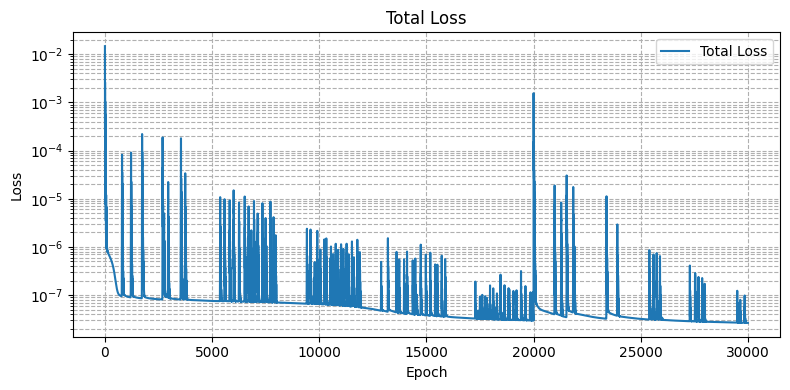

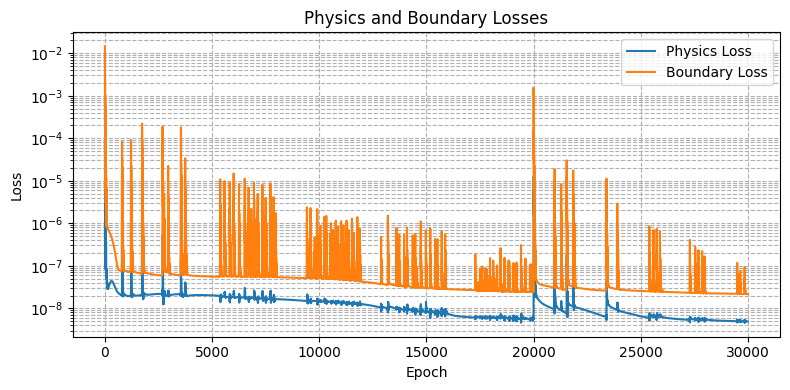

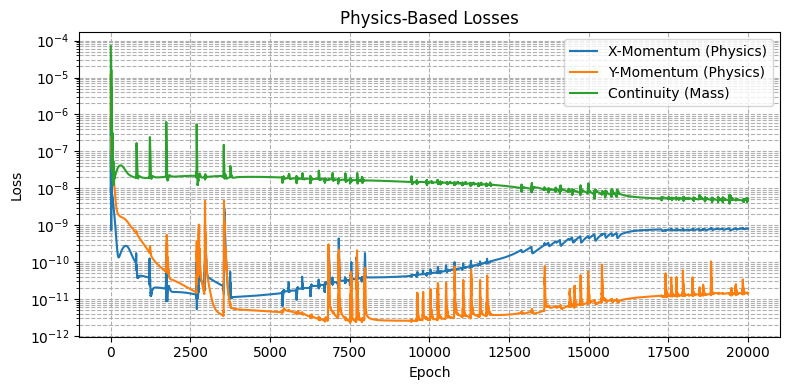

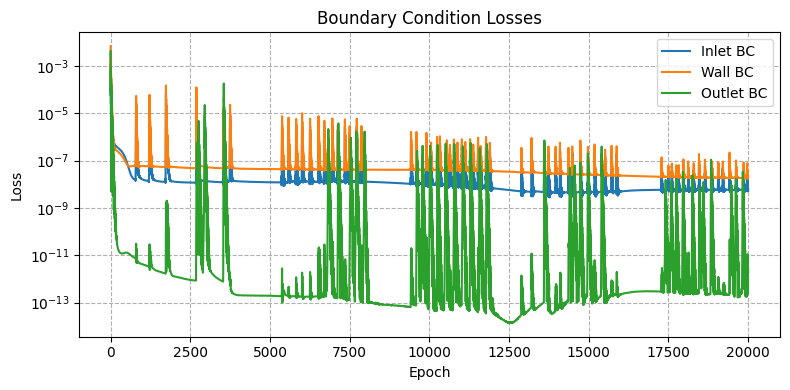

c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\Plots.py:108: UserWarning: Adding colorbar to a different Figure <Figure size 500x200 with 2 Axes> than <Figure size 500x200 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


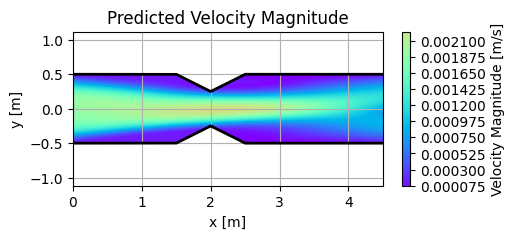

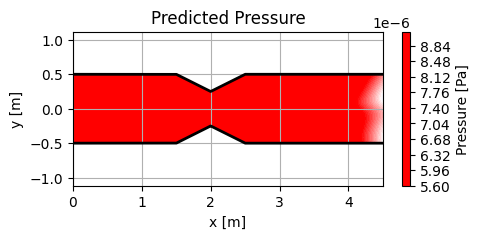

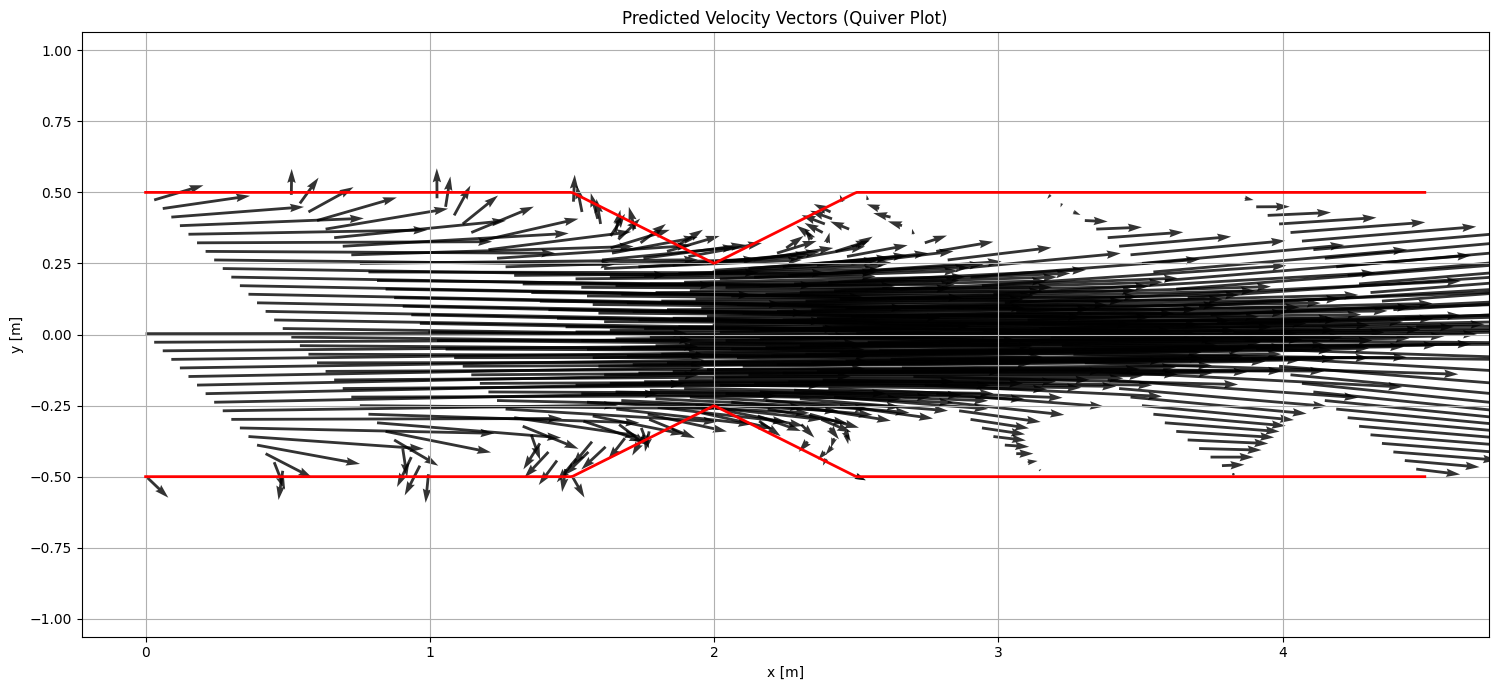

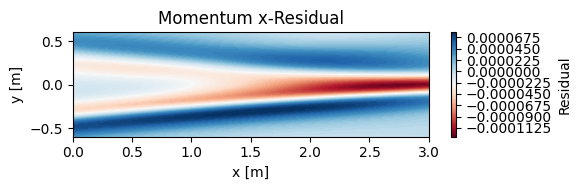

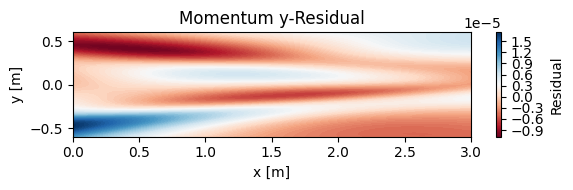

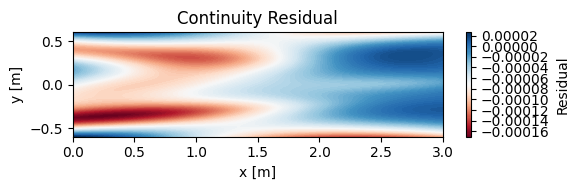

Inlet max velocity: 0.001921092625707388
Outlet max pressure: 4.76837158203125e-07
Wall top max velocity: 0.000387712090741843
Wall bottom max velocity: 0.00041718134889379144


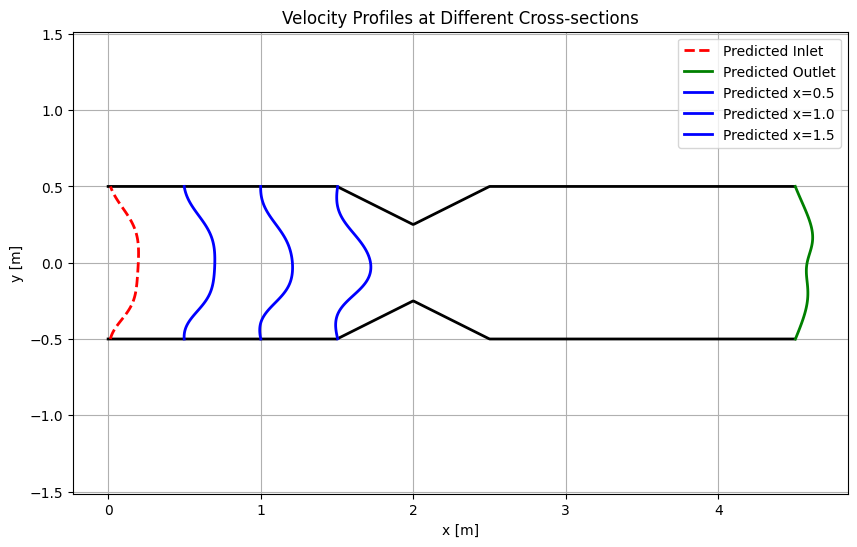

Volumetric flow rate at inlet:  0.001308
Volumetric flow rate at outlet: 0.000743
Relative difference: 43.19%


In [18]:
plot_losses("Total Loss",
                    **{
                        "Total Loss": loss_history
                    })

plot_losses("Physics and Boundary Losses",
                    **{
                        "Physics Loss": physics_loss_history,
                        "Boundary Loss": boundary_loss_history
                    })



# First plot: Physics-related losses
plot_losses(
    "Physics-Based Losses",
    **{
        "X-Momentum (Physics)": loss_phys_x_history,
        "Y-Momentum (Physics)": loss_phys_y_history,
        "Continuity (Mass)": loss_continuity_history
    }
)

# Second plot: Boundary condition losses
plot_losses(
    "Boundary Condition Losses",
    **{
        "Inlet BC": loss_bc_inlet_history,
        "Wall BC": loss_bc_wall_history,
        "Outlet BC": loss_bc_outlet_history
    }
)

fig1, fig2 = predict_and_plot(trained_model, device, sections, x_vals_total, h_total, min_vel=0, max_vel=0.0035, min_pres=-0.000001, max_pres=0.000001)

fig_quiver = predict_and_quiver(trained_model, device, sections, x_vals_total=x_vals_total,
                                h_total=h_total, density=100, scale=0.001, xlim=None, ylim=None, ymin=-0.6, ymax=0.6, y_density=200)

plot_residuals(trained_model, device, x_range= (0,3), y_range = (-0.6, 0.6), x_points = 200, y_points = 100,
                     x_y_inlet=x_y_inlet, x_y_outlet=x_y_outlet, x_y_top=x_y_top, x_y_bottom=x_y_bottom)

x_locs= [0.5, 1.0, 1.5]

plot_velocity_profiles(trained_model, device, x_vals_total=x_vals_total, h_total=h_total, L_total=L_total, x_y_inlet=x_y_inlet,
                       x_y_outlet=x_y_outlet, x_locs=x_locs, scale=100)

validation_by_flux(trained_model, x_vals_total, h_total, L_total)
